In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import time
import copy
import os

In [2]:
batch_size = 64
learning_rate = 0.001

transforms = transforms.Compose(
[
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root='emotion5/train/', transform=transforms)
test_dataset = datasets.ImageFolder(root='emotion5/test/', transform=transforms)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
def imshow(inp, title=None):
    
    inp = inp.cpu() if device else inp
    inp = inp.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

images-size: torch.Size([64, 3, 48, 48])
out-size: torch.Size([3, 402, 402])


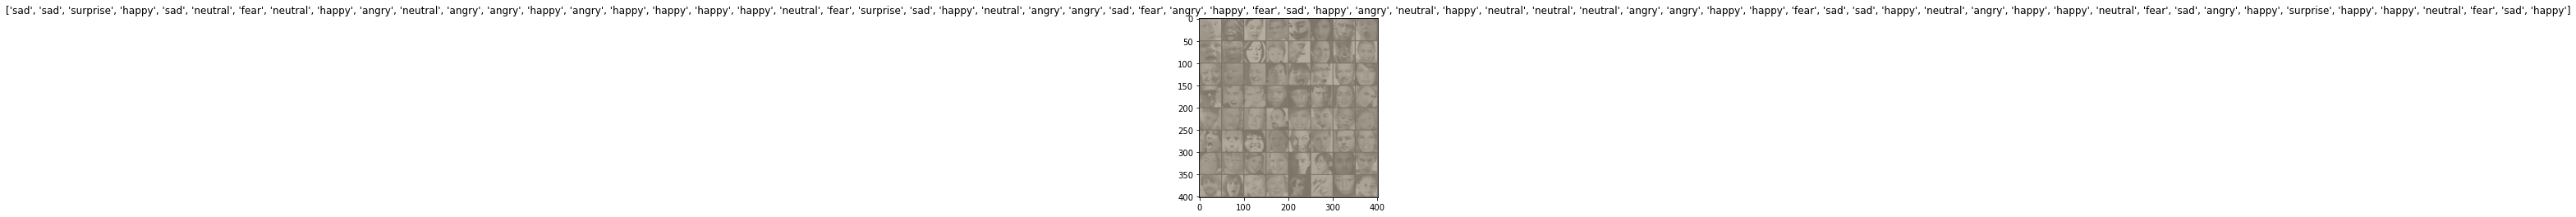

In [4]:
images, labels = next(iter(train_dataloader)) 
print("images-size:", images.shape)

out = torchvision.utils.make_grid(images)
print("out-size:", out.shape)

imshow(out, title=[train_dataset.classes[x] for x in labels])

In [5]:
net = models.resnet50(pretrained=True)
net = net.cuda() if device else net
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, 
                 betas=(0.9, 0.999), 
                 eps=1e-08, 
                 weight_decay=0, 
                 amsgrad=False)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 128)
net.fc = net.fc.cuda() if device else net.fc

In [7]:
n_epochs = 100
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'Resnet5_50_adam_batch64_learninglr0.001_nnlinear128.pt')
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1

Epoch [1/100], Step [0/442], Loss: 4.8382
Epoch [1/100], Step [20/442], Loss: 3.1948
Epoch [1/100], Step [40/442], Loss: 2.4288
Epoch [1/100], Step [60/442], Loss: 1.5116
Epoch [1/100], Step [80/442], Loss: 1.5480
Epoch [1/100], Step [100/442], Loss: 1.5274
Epoch [1/100], Step [120/442], Loss: 1.6871
Epoch [1/100], Step [140/442], Loss: 1.5904
Epoch [1/100], Step [160/442], Loss: 2.0680
Epoch [1/100], Step [180/442], Loss: 1.8370
Epoch [1/100], Step [200/442], Loss: 1.5479
Epoch [1/100], Step [220/442], Loss: 1.1021
Epoch [1/100], Step [240/442], Loss: 1.1855
Epoch [1/100], Step [260/442], Loss: 1.4637
Epoch [1/100], Step [280/442], Loss: 1.2334
Epoch [1/100], Step [300/442], Loss: 1.4984
Epoch [1/100], Step [320/442], Loss: 1.4459
Epoch [1/100], Step [340/442], Loss: 1.4016
Epoch [1/100], Step [360/442], Loss: 1.2505
Epoch [1/100], Step [380/442], Loss: 1.2103
Epoch [1/100], Step [400/442], Loss: 1.1195
Epoch [1/100], Step [420/442], Loss: 1.4562
Epoch [1/100], Step [440/442]

Epoch [8/100], Step [160/442], Loss: 0.3887
Epoch [8/100], Step [180/442], Loss: 0.6027
Epoch [8/100], Step [200/442], Loss: 0.4987
Epoch [8/100], Step [220/442], Loss: 0.5607
Epoch [8/100], Step [240/442], Loss: 0.4426
Epoch [8/100], Step [260/442], Loss: 0.5841
Epoch [8/100], Step [280/442], Loss: 0.6403
Epoch [8/100], Step [300/442], Loss: 0.4817
Epoch [8/100], Step [320/442], Loss: 0.6960
Epoch [8/100], Step [340/442], Loss: 0.5575
Epoch [8/100], Step [360/442], Loss: 0.6435
Epoch [8/100], Step [380/442], Loss: 0.6235
Epoch [8/100], Step [400/442], Loss: 0.7204
Epoch [8/100], Step [420/442], Loss: 0.3692
Epoch [8/100], Step [440/442], Loss: 0.7856

train-loss: 0.9107, train-acc: 81.3073
validation loss: 1.1555, validation acc: 59.2331

Epoch 9

Epoch [9/100], Step [0/442], Loss: 0.3265
Epoch [9/100], Step [20/442], Loss: 0.4042
Epoch [9/100], Step [40/442], Loss: 0.4418
Epoch [9/100], Step [60/442], Loss: 0.5303
Epoch [9/100], Step [80/442], Loss: 0.5397
Epoch [9/100], Step [100/44

Epoch [15/100], Step [320/442], Loss: 0.1198
Epoch [15/100], Step [340/442], Loss: 0.1199
Epoch [15/100], Step [360/442], Loss: 0.1897
Epoch [15/100], Step [380/442], Loss: 0.2663
Epoch [15/100], Step [400/442], Loss: 0.2660
Epoch [15/100], Step [420/442], Loss: 0.1445
Epoch [15/100], Step [440/442], Loss: 0.2851

train-loss: 0.6068, train-acc: 94.7087
validation loss: 1.3442, validation acc: 60.8320

Epoch 16

Epoch [16/100], Step [0/442], Loss: 0.1559
Epoch [16/100], Step [20/442], Loss: 0.0392
Epoch [16/100], Step [40/442], Loss: 0.0277
Epoch [16/100], Step [60/442], Loss: 0.0414
Epoch [16/100], Step [80/442], Loss: 0.0598
Epoch [16/100], Step [100/442], Loss: 0.1348
Epoch [16/100], Step [120/442], Loss: 0.0660
Epoch [16/100], Step [140/442], Loss: 0.0837
Epoch [16/100], Step [160/442], Loss: 0.0422
Epoch [16/100], Step [180/442], Loss: 0.1111
Epoch [16/100], Step [200/442], Loss: 0.0873
Epoch [16/100], Step [220/442], Loss: 0.1658
Epoch [16/100], Step [240/442], Loss: 0.1076
Epoch 

validation loss: 1.5209, validation acc: 60.5207

Epoch 23

Epoch [23/100], Step [0/442], Loss: 0.1178
Epoch [23/100], Step [20/442], Loss: 0.0739
Epoch [23/100], Step [40/442], Loss: 0.0495
Epoch [23/100], Step [60/442], Loss: 0.0175
Epoch [23/100], Step [80/442], Loss: 0.0691
Epoch [23/100], Step [100/442], Loss: 0.0178
Epoch [23/100], Step [120/442], Loss: 0.0476
Epoch [23/100], Step [140/442], Loss: 0.1006
Epoch [23/100], Step [160/442], Loss: 0.0426
Epoch [23/100], Step [180/442], Loss: 0.0320
Epoch [23/100], Step [200/442], Loss: 0.1398
Epoch [23/100], Step [220/442], Loss: 0.0214
Epoch [23/100], Step [240/442], Loss: 0.0942
Epoch [23/100], Step [260/442], Loss: 0.1410
Epoch [23/100], Step [280/442], Loss: 0.0472
Epoch [23/100], Step [300/442], Loss: 0.2456
Epoch [23/100], Step [320/442], Loss: 0.0468
Epoch [23/100], Step [340/442], Loss: 0.1083
Epoch [23/100], Step [360/442], Loss: 0.1176
Epoch [23/100], Step [380/442], Loss: 0.2163
Epoch [23/100], Step [400/442], Loss: 0.1017
E

Epoch [30/100], Step [120/442], Loss: 0.0346
Epoch [30/100], Step [140/442], Loss: 0.1499
Epoch [30/100], Step [160/442], Loss: 0.0323
Epoch [30/100], Step [180/442], Loss: 0.0552
Epoch [30/100], Step [200/442], Loss: 0.1259
Epoch [30/100], Step [220/442], Loss: 0.0337
Epoch [30/100], Step [240/442], Loss: 0.0412
Epoch [30/100], Step [260/442], Loss: 0.0374
Epoch [30/100], Step [280/442], Loss: 0.0661
Epoch [30/100], Step [300/442], Loss: 0.0826
Epoch [30/100], Step [320/442], Loss: 0.0387
Epoch [30/100], Step [340/442], Loss: 0.0829
Epoch [30/100], Step [360/442], Loss: 0.1050
Epoch [30/100], Step [380/442], Loss: 0.0116
Epoch [30/100], Step [400/442], Loss: 0.2110
Epoch [30/100], Step [420/442], Loss: 0.0857
Epoch [30/100], Step [440/442], Loss: 0.1080

train-loss: 0.3517, train-acc: 97.7222
validation loss: 1.6629, validation acc: 60.5773

Epoch 31

Epoch [31/100], Step [0/442], Loss: 0.0655
Epoch [31/100], Step [20/442], Loss: 0.0672
Epoch [31/100], Step [40/442], Loss: 0.0727
Epoc

Epoch [37/100], Step [260/442], Loss: 0.0388
Epoch [37/100], Step [280/442], Loss: 0.0202
Epoch [37/100], Step [300/442], Loss: 0.0918
Epoch [37/100], Step [320/442], Loss: 0.0320
Epoch [37/100], Step [340/442], Loss: 0.0693
Epoch [37/100], Step [360/442], Loss: 0.0719
Epoch [37/100], Step [380/442], Loss: 0.0185
Epoch [37/100], Step [400/442], Loss: 0.0906
Epoch [37/100], Step [420/442], Loss: 0.1557
Epoch [37/100], Step [440/442], Loss: 0.0249

train-loss: 0.2972, train-acc: 97.8991
validation loss: 1.7508, validation acc: 60.9594

Epoch 38

Epoch [38/100], Step [0/442], Loss: 0.0427
Epoch [38/100], Step [20/442], Loss: 0.0820
Epoch [38/100], Step [40/442], Loss: 0.0847
Epoch [38/100], Step [60/442], Loss: 0.0384
Epoch [38/100], Step [80/442], Loss: 0.0517
Epoch [38/100], Step [100/442], Loss: 0.0361
Epoch [38/100], Step [120/442], Loss: 0.0082
Epoch [38/100], Step [140/442], Loss: 0.0206
Epoch [38/100], Step [160/442], Loss: 0.0171
Epoch [38/100], Step [180/442], Loss: 0.0761
Epoch 

Epoch [44/100], Step [400/442], Loss: 0.0513
Epoch [44/100], Step [420/442], Loss: 0.0375
Epoch [44/100], Step [440/442], Loss: 0.1457

train-loss: 0.2583, train-acc: 98.2103
validation loss: 1.8295, validation acc: 61.8084

Epoch 45

Epoch [45/100], Step [0/442], Loss: 0.1767
Epoch [45/100], Step [20/442], Loss: 0.0361
Epoch [45/100], Step [40/442], Loss: 0.0634
Epoch [45/100], Step [60/442], Loss: 0.0259
Epoch [45/100], Step [80/442], Loss: 0.0220
Epoch [45/100], Step [100/442], Loss: 0.0070
Epoch [45/100], Step [120/442], Loss: 0.0782
Epoch [45/100], Step [140/442], Loss: 0.0012
Epoch [45/100], Step [160/442], Loss: 0.0062
Epoch [45/100], Step [180/442], Loss: 0.0187
Epoch [45/100], Step [200/442], Loss: 0.0178
Epoch [45/100], Step [220/442], Loss: 0.0283
Epoch [45/100], Step [240/442], Loss: 0.0059
Epoch [45/100], Step [260/442], Loss: 0.0035
Epoch [45/100], Step [280/442], Loss: 0.0263
Epoch [45/100], Step [300/442], Loss: 0.0191
Epoch [45/100], Step [320/442], Loss: 0.0208
Epoch 

Epoch [52/100], Step [40/442], Loss: 0.0023
Epoch [52/100], Step [60/442], Loss: 0.0045
Epoch [52/100], Step [80/442], Loss: 0.0207
Epoch [52/100], Step [100/442], Loss: 0.0400
Epoch [52/100], Step [120/442], Loss: 0.0122
Epoch [52/100], Step [140/442], Loss: 0.0881
Epoch [52/100], Step [160/442], Loss: 0.0055
Epoch [52/100], Step [180/442], Loss: 0.0157
Epoch [52/100], Step [200/442], Loss: 0.0072
Epoch [52/100], Step [220/442], Loss: 0.0282
Epoch [52/100], Step [240/442], Loss: 0.0264
Epoch [52/100], Step [260/442], Loss: 0.0327
Epoch [52/100], Step [280/442], Loss: 0.0288
Epoch [52/100], Step [300/442], Loss: 0.1154
Epoch [52/100], Step [320/442], Loss: 0.0120
Epoch [52/100], Step [340/442], Loss: 0.0147
Epoch [52/100], Step [360/442], Loss: 0.0992
Epoch [52/100], Step [380/442], Loss: 0.0320
Epoch [52/100], Step [400/442], Loss: 0.0087
Epoch [52/100], Step [420/442], Loss: 0.0268
Epoch [52/100], Step [440/442], Loss: 0.0728

train-loss: 0.2253, train-acc: 98.7762
validation loss: 1

Epoch [59/100], Step [180/442], Loss: 0.0259
Epoch [59/100], Step [200/442], Loss: 0.0158
Epoch [59/100], Step [220/442], Loss: 0.0050
Epoch [59/100], Step [240/442], Loss: 0.0717
Epoch [59/100], Step [260/442], Loss: 0.0111
Epoch [59/100], Step [280/442], Loss: 0.0110
Epoch [59/100], Step [300/442], Loss: 0.0364
Epoch [59/100], Step [320/442], Loss: 0.0385
Epoch [59/100], Step [340/442], Loss: 0.0178
Epoch [59/100], Step [360/442], Loss: 0.0377
Epoch [59/100], Step [380/442], Loss: 0.0115
Epoch [59/100], Step [400/442], Loss: 0.0128
Epoch [59/100], Step [420/442], Loss: 0.0109
Epoch [59/100], Step [440/442], Loss: 0.1304

train-loss: 0.2032, train-acc: 98.9778
validation loss: 1.9605, validation acc: 61.2141

Epoch 60

Epoch [60/100], Step [0/442], Loss: 0.0150
Epoch [60/100], Step [20/442], Loss: 0.0162
Epoch [60/100], Step [40/442], Loss: 0.0005
Epoch [60/100], Step [60/442], Loss: 0.0524
Epoch [60/100], Step [80/442], Loss: 0.0627
Epoch [60/100], Step [100/442], Loss: 0.0587
Epoch 

Epoch [66/100], Step [320/442], Loss: 0.0289
Epoch [66/100], Step [340/442], Loss: 0.0235
Epoch [66/100], Step [360/442], Loss: 0.0443
Epoch [66/100], Step [380/442], Loss: 0.1095
Epoch [66/100], Step [400/442], Loss: 0.0681
Epoch [66/100], Step [420/442], Loss: 0.2053
Epoch [66/100], Step [440/442], Loss: 0.0036

train-loss: 0.1853, train-acc: 99.0380
validation loss: 2.0086, validation acc: 60.4500

Epoch 67

Epoch [67/100], Step [0/442], Loss: 0.0351
Epoch [67/100], Step [20/442], Loss: 0.0317
Epoch [67/100], Step [40/442], Loss: 0.0615
Epoch [67/100], Step [60/442], Loss: 0.0220
Epoch [67/100], Step [80/442], Loss: 0.0140
Epoch [67/100], Step [100/442], Loss: 0.0311
Epoch [67/100], Step [120/442], Loss: 0.0314
Epoch [67/100], Step [140/442], Loss: 0.0352
Epoch [67/100], Step [160/442], Loss: 0.0811
Epoch [67/100], Step [180/442], Loss: 0.0177
Epoch [67/100], Step [200/442], Loss: 0.0480
Epoch [67/100], Step [220/442], Loss: 0.1749
Epoch [67/100], Step [240/442], Loss: 0.0214
Epoch 

validation loss: 2.0565, validation acc: 60.7471

Epoch 74

Epoch [74/100], Step [0/442], Loss: 0.0159
Epoch [74/100], Step [20/442], Loss: 0.0042
Epoch [74/100], Step [40/442], Loss: 0.0154
Epoch [74/100], Step [60/442], Loss: 0.0078
Epoch [74/100], Step [80/442], Loss: 0.0404
Epoch [74/100], Step [100/442], Loss: 0.0031
Epoch [74/100], Step [120/442], Loss: 0.0032
Epoch [74/100], Step [140/442], Loss: 0.0160
Epoch [74/100], Step [160/442], Loss: 0.0718
Epoch [74/100], Step [180/442], Loss: 0.0186
Epoch [74/100], Step [200/442], Loss: 0.0015
Epoch [74/100], Step [220/442], Loss: 0.0033
Epoch [74/100], Step [240/442], Loss: 0.0010
Epoch [74/100], Step [260/442], Loss: 0.0021
Epoch [74/100], Step [280/442], Loss: 0.0399
Epoch [74/100], Step [300/442], Loss: 0.0011
Epoch [74/100], Step [320/442], Loss: 0.0278
Epoch [74/100], Step [340/442], Loss: 0.1119
Epoch [74/100], Step [360/442], Loss: 0.0268
Epoch [74/100], Step [380/442], Loss: 0.0208
Epoch [74/100], Step [400/442], Loss: 0.0106
E

Epoch [81/100], Step [120/442], Loss: 0.0098
Epoch [81/100], Step [140/442], Loss: 0.0717
Epoch [81/100], Step [160/442], Loss: 0.0159
Epoch [81/100], Step [180/442], Loss: 0.0192
Epoch [81/100], Step [200/442], Loss: 0.1380
Epoch [81/100], Step [220/442], Loss: 0.0159
Epoch [81/100], Step [240/442], Loss: 0.0423
Epoch [81/100], Step [260/442], Loss: 0.0226
Epoch [81/100], Step [280/442], Loss: 0.0369
Epoch [81/100], Step [300/442], Loss: 0.0132
Epoch [81/100], Step [320/442], Loss: 0.0337
Epoch [81/100], Step [340/442], Loss: 0.0136
Epoch [81/100], Step [360/442], Loss: 0.0524
Epoch [81/100], Step [380/442], Loss: 0.0249
Epoch [81/100], Step [400/442], Loss: 0.0681
Epoch [81/100], Step [420/442], Loss: 0.0018
Epoch [81/100], Step [440/442], Loss: 0.0420

train-loss: 0.1566, train-acc: 98.8823
validation loss: 2.1059, validation acc: 61.1575

Epoch 82

Epoch [82/100], Step [0/442], Loss: 0.0148
Epoch [82/100], Step [20/442], Loss: 0.0115
Epoch [82/100], Step [40/442], Loss: 0.0073
Epoc

Epoch [88/100], Step [260/442], Loss: 0.0317
Epoch [88/100], Step [280/442], Loss: 0.0102
Epoch [88/100], Step [300/442], Loss: 0.0176
Epoch [88/100], Step [320/442], Loss: 0.0134
Epoch [88/100], Step [340/442], Loss: 0.0131
Epoch [88/100], Step [360/442], Loss: 0.0436
Epoch [88/100], Step [380/442], Loss: 0.0744
Epoch [88/100], Step [400/442], Loss: 0.0498
Epoch [88/100], Step [420/442], Loss: 0.0262
Epoch [88/100], Step [440/442], Loss: 0.0087

train-loss: 0.1463, train-acc: 99.1334
validation loss: 2.1411, validation acc: 60.6481

Epoch 89

Epoch [89/100], Step [0/442], Loss: 0.0009
Epoch [89/100], Step [20/442], Loss: 0.0009
Epoch [89/100], Step [40/442], Loss: 0.0156
Epoch [89/100], Step [60/442], Loss: 0.0006
Epoch [89/100], Step [80/442], Loss: 0.0119
Epoch [89/100], Step [100/442], Loss: 0.0016
Epoch [89/100], Step [120/442], Loss: 0.0075
Epoch [89/100], Step [140/442], Loss: 0.0027
Epoch [89/100], Step [160/442], Loss: 0.0144
Epoch [89/100], Step [180/442], Loss: 0.0052
Epoch 

Epoch [95/100], Step [400/442], Loss: 0.0090
Epoch [95/100], Step [420/442], Loss: 0.0032
Epoch [95/100], Step [440/442], Loss: 0.0061

train-loss: 0.1373, train-acc: 99.3032
validation loss: 2.1751, validation acc: 61.4405

Epoch 96

Epoch [96/100], Step [0/442], Loss: 0.0013
Epoch [96/100], Step [20/442], Loss: 0.0072
Epoch [96/100], Step [40/442], Loss: 0.0482
Epoch [96/100], Step [60/442], Loss: 0.0204
Epoch [96/100], Step [80/442], Loss: 0.0021
Epoch [96/100], Step [100/442], Loss: 0.0231
Epoch [96/100], Step [120/442], Loss: 0.0072
Epoch [96/100], Step [140/442], Loss: 0.0661
Epoch [96/100], Step [160/442], Loss: 0.0167
Epoch [96/100], Step [180/442], Loss: 0.0462
Epoch [96/100], Step [200/442], Loss: 0.0021
Epoch [96/100], Step [220/442], Loss: 0.0015
Epoch [96/100], Step [240/442], Loss: 0.0132
Epoch [96/100], Step [260/442], Loss: 0.0013
Epoch [96/100], Step [280/442], Loss: 0.0014
Epoch [96/100], Step [300/442], Loss: 0.1394
Epoch [96/100], Step [320/442], Loss: 0.0243
Epoch 

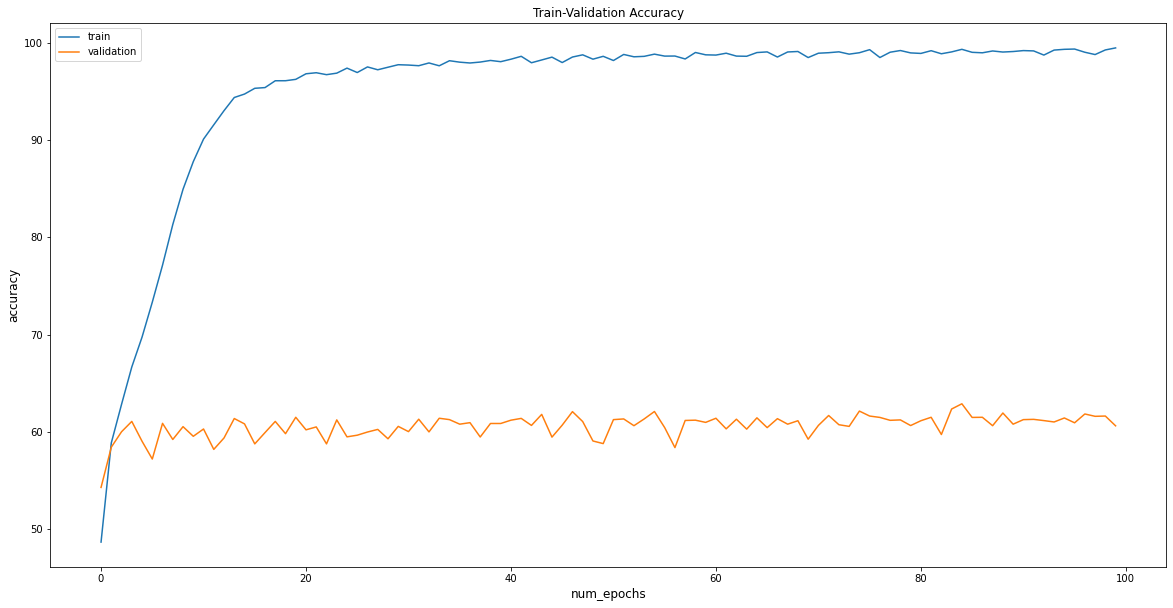

In [8]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

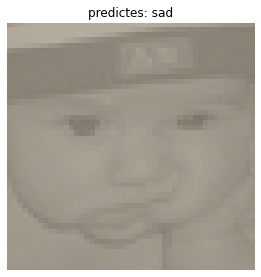

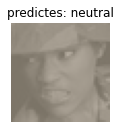

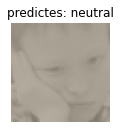

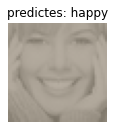

In [9]:
def visualize_model(net, num_images=4):
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))
    
    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        if device:
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu().numpy() if device else preds.numpy()
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(2, num_images//2, images_so_far)
            ax.axis('off')
            ax.set_title('predictes: {}'.format(test_dataset.classes[preds[j]]))
            imshow(inputs[j])
            
            if images_so_far == num_images:
                return 

plt.ion()
visualize_model(net)
plt.ioff()